Se debe descargar el dataset del enlace https://www.kaggle.com/datasets/prepinstaprime/black-friday-sales-data

# Exploración y limpieza

In [56]:
# preprocessing
import pandas
import numpy as np

# visualization
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns

# machine learing
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.preprocessing import Normalizer

# deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset


In [4]:
sales_df = pandas.read_csv("./train.csv")

In [5]:
sales_df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [6]:
print("Dimensiones del dataset:\n")
print(sales_df.shape)
print("\nTipos de las columnas y cantidad de valores únicos:\n")

column_types = sales_df.dtypes
uniques = sales_df.nunique()

column_summary = pandas.concat([column_types, uniques], axis=1, keys=["dtype", "uniques"])

print(column_summary)

Dimensiones del dataset:

(550068, 12)

Tipos de las columnas y cantidad de valores únicos:

                              dtype  uniques
User_ID                       int64     5891
Product_ID                   object     3631
Gender                       object        2
Age                          object        7
Occupation                    int64       21
City_Category                object        3
Stay_In_Current_City_Years   object        5
Marital_Status                int64        2
Product_Category_1            int64       20
Product_Category_2          float64       17
Product_Category_3          float64       15
Purchase                      int64    18105


Observamos que el dataset no presenta columna de tipo identificador único, que las columnas `Gender`, `Age`, `City_Category` y `Stay_In_Current_City_Years` son categóricas de tipo objecto (string) y que `Occupation` y `Marital_Status` son categóricas codificadas como entero.


Conteo absoluto y porcentual de valores nulos por columna.

In [7]:
nan_counts = sales_df.isnull().sum()
nan_pct = round(nan_counts / len(sales_df), 2)

nan_summary = pandas.concat([nan_counts, nan_pct], axis=1, keys=["count", "pct"])

print(nan_summary)

                             count   pct
User_ID                          0  0.00
Product_ID                       0  0.00
Gender                           0  0.00
Age                              0  0.00
Occupation                       0  0.00
City_Category                    0  0.00
Stay_In_Current_City_Years       0  0.00
Marital_Status                   0  0.00
Product_Category_1               0  0.00
Product_Category_2          173638  0.32
Product_Category_3          383247  0.70
Purchase                         0  0.00


Sólo las columnas `Product_Category_2` y `Product_Category_3` tienen valores nulos, 173.638 y 383.247, lo que representa un 32% y un 70% de valores nulos sobre el total de los datos, respectivamente.

In [8]:
sales_df.duplicated().sum()

np.int64(0)

El dataset no presenta columnas duplicadas.

In [9]:
print("Valores únicos de las columnas Product_Category 1, 2 y 3:\n")

print("Product_Category_1")
print(sorted(sales_df['Product_Category_1'].unique()))

print("Product_Category_2")
print(sorted(sales_df['Product_Category_2'].unique()))

print("Product_Category_3")
print(sorted(sales_df['Product_Category_3'].unique()))


Valores únicos de las columnas Product_Category 1, 2 y 3:

Product_Category_1
[np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20)]
Product_Category_2
[np.float64(nan), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0), np.float64(7.0), np.float64(8.0), np.float64(9.0), np.float64(10.0), np.float64(11.0), np.float64(12.0), np.float64(13.0), np.float64(14.0), np.float64(15.0), np.float64(16.0), np.float64(17.0), np.float64(18.0)]
Product_Category_3
[np.float64(nan), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0), np.float64(8.0), np.float64(9.0), np.float64(10.0), np.float64(11.0), np.float64(12.0), np.float64(13.0), np.float64(14.0), np.float64(15.0), np.float64(16.0), np.float64(17.0), np.float64(18.0)]


Como vimos antes, ProdCat1 es de tipo entero y no tiene valores nulos, mientras que ProdCat2 y ProdCat3 son de tipo flotante y sí tiene valores nulos.

los valores de ProdCat1 van del 1 al 20;
los de ProdCat 2, del 2 al 18;
los de ProdCat 3, del 3 al 18 (saltándose el 7).

In [10]:
condition_a = sales_df['Product_Category_2'].isnull() & sales_df['Product_Category_3'].notnull()
all_nulls_in_2_are_null_in_3 = not condition_a.any()

condition_b = sales_df['Product_Category_3'].isnull() & sales_df['Product_Category_2'].notnull()
all_nulls_in_3_are_null_in_2 = not condition_b.any()

print("¿Todos los nulos en Product_Category_2 son también nulos en Product_Category_3?")
print(all_nulls_in_2_are_null_in_3)

print("¿Todos los nulos en Product_Category_3 son también nulos en Product_Category_2?")
print(all_nulls_in_3_are_null_in_2)

¿Todos los nulos en Product_Category_2 son también nulos en Product_Category_3?
True
¿Todos los nulos en Product_Category_3 son también nulos en Product_Category_2?
False


In [11]:
# Tabla cruzada de valores nulos
crosstab = pandas.crosstab(sales_df['Product_Category_2'].isnull(), sales_df['Product_Category_3'].isnull(), rownames=['2 is null'], colnames=['3 is null'])
print(crosstab)

3 is null   False   True 
2 is null                
False      166821  209609
True            0  173638


In [12]:
null_pc2 = sales_df['Product_Category_2'].isnull().astype(int)
null_pc3 = sales_df['Product_Category_3'].isnull().astype(int)

# Calcular la correlación
correlation = null_pc2.corr(null_pc3)
print(f"Correlación entre los nulos de ProdCat2 y ProdCat3: {round(correlation, 2)}")

Correlación entre los nulos de ProdCat2 y ProdCat3: 0.45


# Preprocesamiento

Creamos una copia del DataFrame para realizar el preprocesamiento sobre éste sin modificar al objeto original.

In [13]:
cleaned_sales = sales_df.copy()

Codificamos las varibales categóricas en valores numéricos.

In [14]:
def generate_map(unique_values):
    return {value: idx for idx, value in enumerate(unique_values)}

In [15]:
gender_uniques = sales_df['Gender'].unique()
age_uniques = sorted(sales_df['Age'].unique())
city_uniques = sorted(sales_df['City_Category'].unique())
stay_in_city_uniques = sorted(sales_df['Stay_In_Current_City_Years'].unique())

gender_map = generate_map(gender_uniques)
age_map = generate_map(age_uniques)
city_map = generate_map(city_uniques)
stay_in_city_map = generate_map(stay_in_city_uniques)

print(gender_map)
print(age_map)
print(city_map)
print(stay_in_city_map)

{'F': 0, 'M': 1}
{'0-17': 0, '18-25': 1, '26-35': 2, '36-45': 3, '46-50': 4, '51-55': 5, '55+': 6}
{'A': 0, 'B': 1, 'C': 2}
{'0': 0, '1': 1, '2': 2, '3': 3, '4+': 4}


In [16]:
cleaned_sales['Gender'] = sales_df['Gender'].map(gender_map)
cleaned_sales['Age'] = sales_df['Age'].map(age_map)
cleaned_sales['City_Category'] = sales_df['City_Category'].map(city_map)
cleaned_sales['Stay_In_Current_City_Years'] = sales_df['Stay_In_Current_City_Years'].map(stay_in_city_map)

Verificamos que el Product_ID de todos los registros cumpla con la forma “carácter ´P´ seguido de dígitos (0-9)”.

In [17]:
cumple_formato = sales_df['Product_ID'].str.match(r'^P\d+$').all()

print(cumple_formato)

True


Como se cumple la condición, eliminamos la "P" y convertimos el valor a entero.

In [18]:
cleaned_sales['Product_ID'] = sales_df['Product_ID'].str[1:].astype('int64')

In [19]:
cleaned_sales.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,69042,0,0,10,0,2,0,3,NaN,NaN,8370
1,1000001,248942,0,0,10,0,2,0,1,6.0,14.0,15200
2,1000001,87842,0,0,10,0,2,0,12,NaN,NaN,1422
3,1000001,85442,0,0,10,0,2,0,12,14.0,NaN,1057
4,1000002,285442,1,6,16,2,4,0,8,NaN,NaN,7969


Analizamos los valores de las columnas `Product_Category_2` y `Product_Category_3` para realizar tratamiento de valores faltantes.

In [20]:
columns_with_missing_values = ['Product_Category_2', 'Product_Category_3']

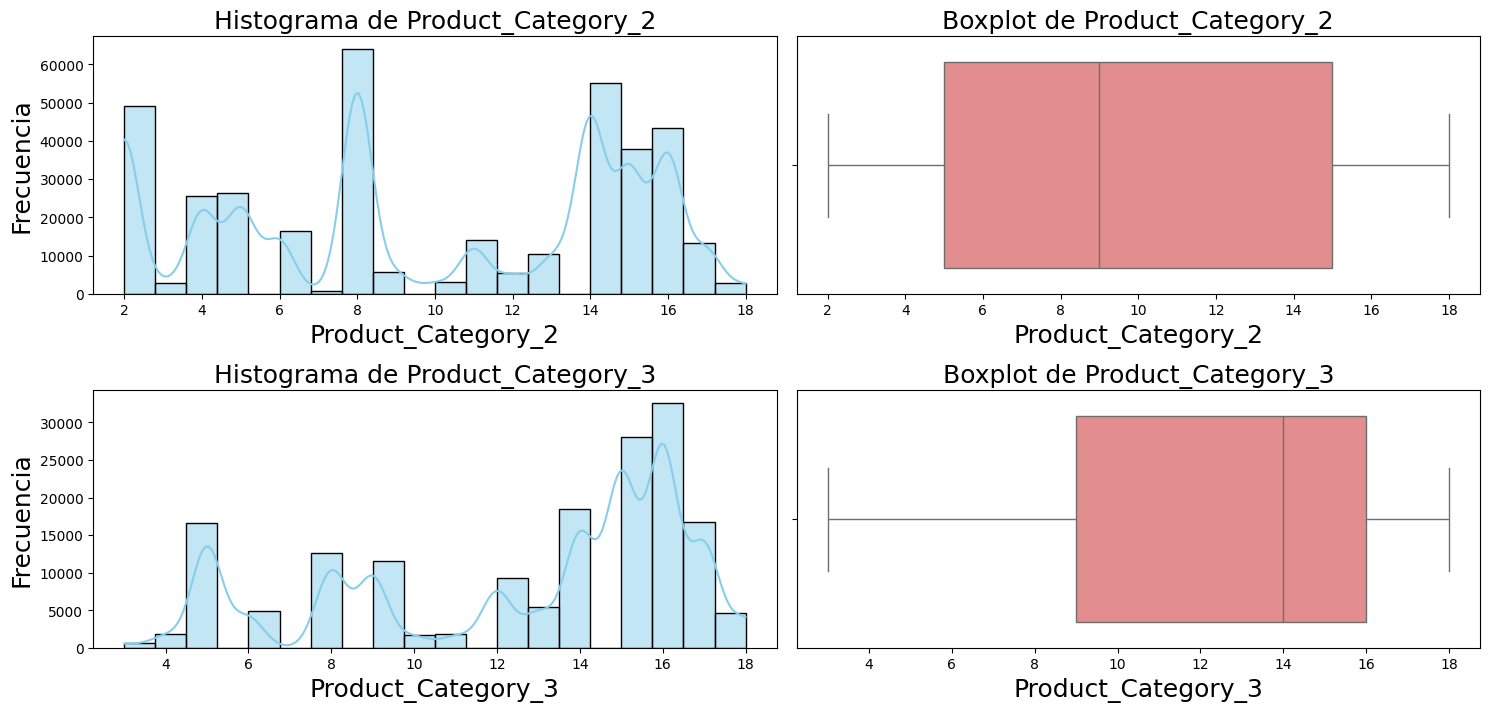

In [21]:
pyplot.figure(figsize=(15, 35))

for i, variable in enumerate(columns_with_missing_values, 1):
    pyplot.subplot(10, 2, i*2-1)
    seaborn.histplot(sales_df[variable], bins=20, kde=True, color='skyblue')
    pyplot.title(f'Histograma de {variable}', fontsize=18)
    pyplot.xlabel(variable, fontsize=18)
    pyplot.ylabel('Frecuencia', fontsize=18)

    pyplot.subplot(10, 2, i*2)
    seaborn.boxplot(x=sales_df[variable], color='lightcoral')
    pyplot.title(f'Boxplot de {variable}', fontsize=18)
    pyplot.xlabel(variable, fontsize=18)

pyplot.subplots_adjust(hspace=0.6)

pyplot.tight_layout()
pyplot.show()


Dado que las columnas no tienen una distribución normal, se procede a imputar los valores nulos respecto a la mediana.

In [22]:
imp_mean = SimpleImputer(missing_values=numpy.nan, strategy='median')

cleaned_sales[columns_with_missing_values] = imp_mean.fit_transform(sales_df[columns_with_missing_values]).astype('int64')

print(cleaned_sales[columns_with_missing_values].head())

   Product_Category_2  Product_Category_3
0                   9                  14
1                   6                  14
2                   9                  14
3                  14                  14
4                   9                  14


Categorización ordinal de la variable objetivo `Purchase`.

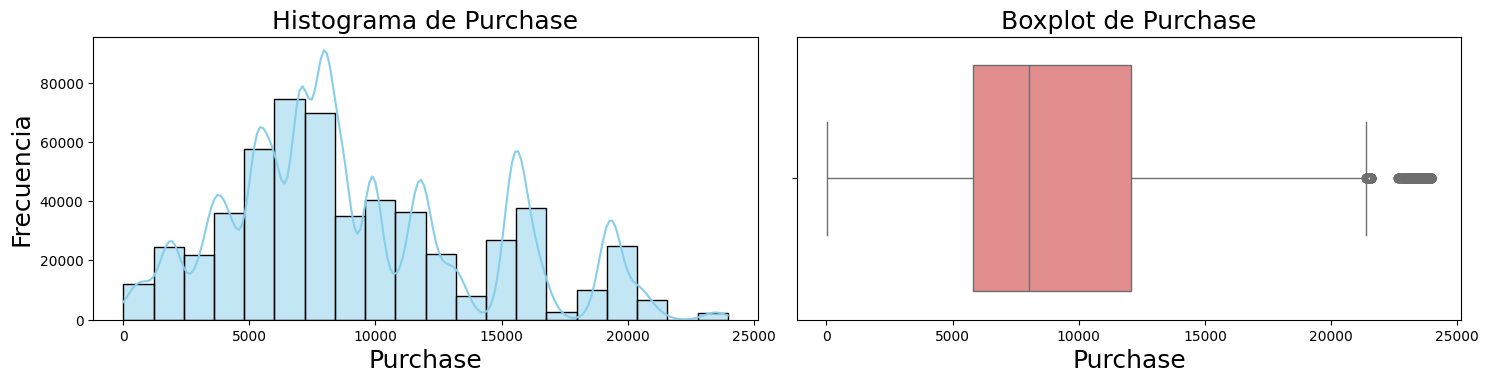

In [23]:
pyplot.figure(figsize=(15, 35))

for i, variable in enumerate(['Purchase'], 1):
    pyplot.subplot(10, 2, i*2-1)
    seaborn.histplot(sales_df[variable], bins=20, kde=True, color='skyblue')
    pyplot.title(f'Histograma de {variable}', fontsize=18)
    pyplot.xlabel(variable, fontsize=18)
    pyplot.ylabel('Frecuencia', fontsize=18)

    pyplot.subplot(10, 2, i*2)
    seaborn.boxplot(x=sales_df[variable], color='lightcoral')
    pyplot.title(f'Boxplot de {variable}', fontsize=18)
    pyplot.xlabel(variable, fontsize=18)

pyplot.subplots_adjust(hspace=0.6)

pyplot.tight_layout()
pyplot.show()

In [24]:
min_valor = sales_df['Purchase'].min()
max_valor = sales_df['Purchase'].max()
media = sales_df['Purchase'].mean()
mediana = sales_df['Purchase'].median()

print(f"Mínimo: {min_valor}")
print(f"Máximo: {max_valor}")
print(f"Media: {media}")
print(f"Mediana: {mediana}")

Mínimo: 12
Máximo: 23961
Media: 9263.968712959126
Mediana: 8047.0


Definimos los grupos de categorización en base a los cuartiles de la columna.

In [25]:
percentiles = sales_df["Purchase"].quantile([0.25, 0.5, 0.75])

print(percentiles)

cleaned_sales["Purchase"] = pandas.cut(
    sales_df["Purchase"],
    bins=[
        0,
        percentiles[0.25],
        percentiles[0.5],
        percentiles[0.75],
        sales_df["Purchase"].max(),
    ],
    labels=["bajo", "medio-bajo", "medio-alto", "alto"],
)
cleaned_sales["Purchase"] = cleaned_sales["Purchase"].cat.codes.astype("int64")

0.25     5823.0
0.50     8047.0
0.75    12054.0
Name: Purchase, dtype: float64


In [26]:
column_types = cleaned_sales.dtypes
uniques = cleaned_sales.nunique()

column_summary = pandas.concat([column_types, uniques], axis=1, keys=["dtype", "uniques"])

print(column_summary)

                            dtype  uniques
User_ID                     int64     5891
Product_ID                  int64     3631
Gender                      int64        2
Age                         int64        7
Occupation                  int64       21
City_Category               int64        3
Stay_In_Current_City_Years  int64        5
Marital_Status              int64        2
Product_Category_1          int64       20
Product_Category_2          int64       17
Product_Category_3          int64       15
Purchase                    int64        4


Con el DataFrame ya procesado a una matriz de valores enteros, procedemos a almacenarlo en el directorio de trabajo para luego utilizarlo para entrenar modelos.

In [27]:
cleaned_sales

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,69042,0,0,10,0,2,0,3,9,14,2
1,1000001,248942,0,0,10,0,2,0,1,6,14,3
2,1000001,87842,0,0,10,0,2,0,12,9,14,0
3,1000001,85442,0,0,10,0,2,0,12,14,14,0
4,1000002,285442,1,6,16,2,4,0,8,9,14,1
...,...,...,...,...,...,...,...,...,...,...,...,...
550063,1006033,372445,1,5,13,1,1,1,20,9,14,0
550064,1006035,375436,0,2,1,2,3,0,20,9,14,0
550065,1006036,375436,0,2,15,1,4,1,20,9,14,0
550066,1006038,375436,0,6,1,2,2,0,20,9,14,0


In [28]:
cleaned_sales = cleaned_sales.drop(['User_ID', 'Product_ID'], axis=1)
cleaned_sales

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,0,0,10,0,2,0,3,9,14,2
1,0,0,10,0,2,0,1,6,14,3
2,0,0,10,0,2,0,12,9,14,0
3,0,0,10,0,2,0,12,14,14,0
4,1,6,16,2,4,0,8,9,14,1
...,...,...,...,...,...,...,...,...,...,...
550063,1,5,13,1,1,1,20,9,14,0
550064,0,2,1,2,3,0,20,9,14,0
550065,0,2,15,1,4,1,20,9,14,0
550066,0,6,1,2,2,0,20,9,14,0


In [29]:
# Guardar el DataFrame limpio como binario en el directorio
cleaned_sales.to_pickle("sales.pkl")

# Entrenamiento de modelos

In [30]:
sales_train_data = pandas.read_pickle("sales.pkl")

## División del dataset

In [31]:
y = sales_train_data.Purchase
X = sales_train_data.drop('Purchase',axis = 1)

In [32]:
X

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3
0,0,0,10,0,2,0,3,9,14
1,0,0,10,0,2,0,1,6,14
2,0,0,10,0,2,0,12,9,14
3,0,0,10,0,2,0,12,14,14
4,1,6,16,2,4,0,8,9,14
...,...,...,...,...,...,...,...,...,...
550063,1,5,13,1,1,1,20,9,14
550064,0,2,1,2,3,0,20,9,14
550065,0,2,15,1,4,1,20,9,14
550066,0,6,1,2,2,0,20,9,14


In [33]:
y

,Purchase
0,2
1,3
2,0
3,0
4,1
...,...
550063,0
550064,0
550065,0
550066,0


In [34]:
normalizer = Normalizer()

X_normalized = normalizer.fit_transform(X)

In [35]:
RANDOM_STATE = 42

X_train, X_temp, y_train, y_temp = train_test_split(X_normalized, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

# División de temp en validation (50%) y test (50%), es decir, 10% cada uno del total
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=RANDOM_STATE, stratify=y_temp)

# Verificar tamaños
print(f'Train: {len(X_train)}')
print(f'Train: {len(y_train)}')
print(f'Validation: {len(X_val)}')
print(f'Validation: {len(y_val)}')
print(f'Test: {len(X_test)}')
print(f'Test: {len(y_test)}')

Train: 440054
Train: 440054
Validation: 55007
Validation: 55007
Test: 55007
Test: 55007


In [36]:
def metricas(a, b):
  print(f"Accuracy: %.4f" % (accuracy_score(a, b)), '\n'
        f"Presicion: %.4f" % (precision_score(a, b,  average='weighted', labels=np.unique(y_train_predict))), '\n'
        f"Recall: %.4f" % (recall_score(a, b,  average='weighted', labels=np.unique(y_train_predict))), '\n'
        f"F1: %.4f" % (f1_score(a, b,  average='weighted', labels=np.unique(y_train_predict))), '\n')

Modelo Baseline

In [37]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')
lr_clf.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=42)

In [38]:
y_train_predict = lr_clf.predict(X_train)

In [39]:
metricas(y_train, y_train_predict)

Accuracy: 0.3900 
Presicion: 0.3647 
Recall: 0.3900 
F1: 0.3667 



In [40]:
y_val_pred =  lr_clf.predict(X_val)
metricas(y_val, y_val_pred)

Accuracy: 0.3889 
Presicion: 0.3639 
Recall: 0.3889 
F1: 0.3660 



## Red Neuronal Multicapa (MLP)

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [43]:
# Convertir datos a tensores
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values.ravel(), dtype=torch.long).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val.values.ravel(), dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values.ravel(), dtype=torch.long).to(device)

In [44]:
batch_size = 64

# Crear conjuntos de datos y DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [45]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        return self.fc4(x)

input_size = X_train.shape[1]
output_size = len(np.unique(y_train))
model = MLP(input_size, output_size).to(device)

In [46]:
class_counts = y_train.value_counts().to_list()
total_samples = sum(class_counts)
weights = torch.tensor([total_samples / c for c in class_counts], dtype=torch.float32).to(device)

In [47]:
loss_function = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)  # penalty


Entrenamiento

In [48]:
epochs = 40
train_loss_by_epoch = []
valid_loss_by_epoch = []
train_metric_by_epoch = []
valid_metric_by_epoch = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    epoch_y, epoch_y_hat = [], []

    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        mlp_output = model(x_batch)

        loss = loss_function(mlp_output, y_batch)
        loss.backward()
        optimizer.step()

        epoch_y.extend(y_batch.cpu().numpy())
        epoch_y_hat.extend(torch.argmax(mlp_output, dim=1).cpu().numpy())
        epoch_loss += loss.item()

    train_loss_by_epoch.append(epoch_loss / len(train_loader))
    train_metric_by_epoch.append(metrics.f1_score(epoch_y, epoch_y_hat, average='weighted'))

    # Validación
    model.eval()
    valid_epoch_loss = 0
    valid_epoch_y, valid_epoch_y_hat = [], []

    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            mlp_output = model(x_batch)
            loss = loss_function(mlp_output, y_batch)

            valid_epoch_y.extend(y_batch.cpu().numpy())
            valid_epoch_y_hat.extend(torch.argmax(mlp_output, dim=1).cpu().numpy())
            valid_epoch_loss += loss.item()

    valid_loss_by_epoch.append(valid_epoch_loss / len(val_loader))
    valid_metric_by_epoch.append(metrics.f1_score(valid_epoch_y, valid_epoch_y_hat, average='weighted'))

    print(f" Epoch {epoch} | "
          f"Train/Val loss: {train_loss_by_epoch[-1]:.3f} / {valid_loss_by_epoch[-1]:.3f} | "
          f"Train/Val F1-score: {train_metric_by_epoch[-1]:.3f} / {valid_metric_by_epoch[-1]:.3f}")


 Epoch 0 | Train/Val loss: 1.330 / 1.254 | Train/Val F1-score: 0.326 / 0.330
 Epoch 1 | Train/Val loss: 1.242 / 1.231 | Train/Val F1-score: 0.370 / 0.369
 Epoch 2 | Train/Val loss: 1.214 / 1.193 | Train/Val F1-score: 0.398 / 0.402
 Epoch 3 | Train/Val loss: 1.174 / 1.165 | Train/Val F1-score: 0.424 / 0.416
 Epoch 4 | Train/Val loss: 1.162 / 1.162 | Train/Val F1-score: 0.415 / 0.423
 Epoch 5 | Train/Val loss: 1.159 / 1.159 | Train/Val F1-score: 0.414 / 0.417
 Epoch 6 | Train/Val loss: 1.155 / 1.154 | Train/Val F1-score: 0.417 / 0.418
 Epoch 7 | Train/Val loss: 1.151 / 1.147 | Train/Val F1-score: 0.422 / 0.424
 Epoch 8 | Train/Val loss: 1.144 / 1.137 | Train/Val F1-score: 0.431 / 0.426
 Epoch 9 | Train/Val loss: 1.131 / 1.120 | Train/Val F1-score: 0.440 / 0.437
 Epoch 10 | Train/Val loss: 1.112 / 1.096 | Train/Val F1-score: 0.449 / 0.459
 Epoch 11 | Train/Val loss: 1.087 / 1.085 | Train/Val F1-score: 0.467 / 0.459
 Epoch 12 | Train/Val loss: 1.068 / 1.050 | Train/Val F1-score: 0.478 / 0.

### Gráficos

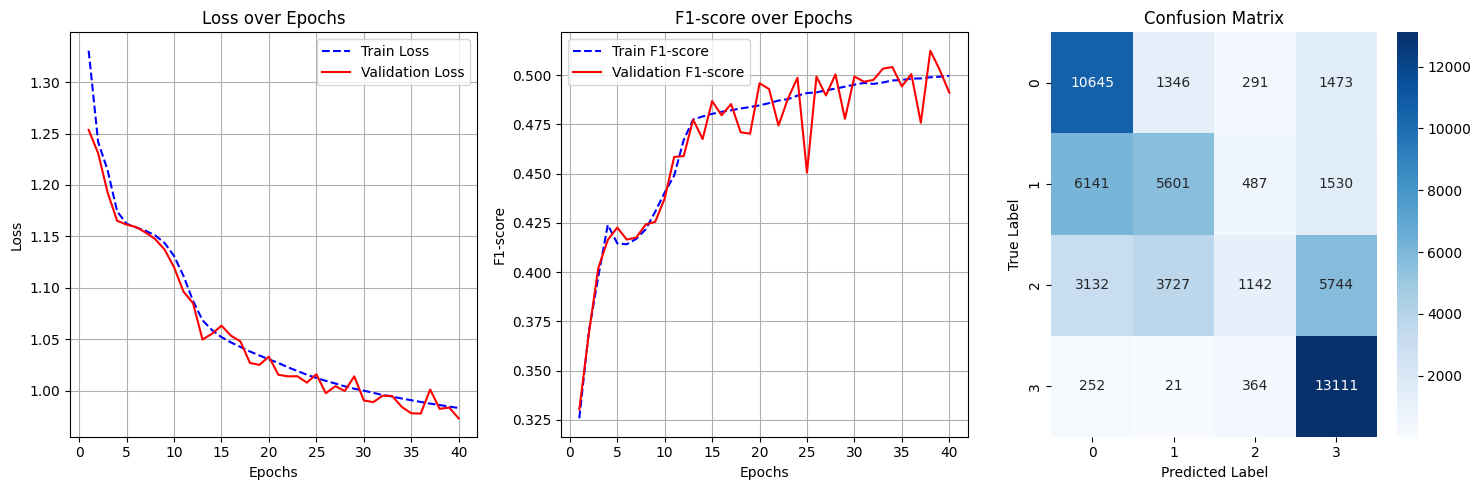

In [58]:
conf_matrix = metrics.confusion_matrix(valid_epoch_y, valid_epoch_y_hat)

# subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Loss
axes[0].plot(range(1, epochs + 1), train_loss_by_epoch, label="Train Loss", color='blue', linestyle='--')
axes[0].plot(range(1, epochs + 1), valid_loss_by_epoch, label="Validation Loss", color='red')
axes[0].set_title("Loss over Epochs")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid()

# F1-score
axes[1].plot(range(1, epochs + 1), train_metric_by_epoch, label="Train F1-score", color='blue', linestyle='--')
axes[1].plot(range(1, epochs + 1), valid_metric_by_epoch, label="Validation F1-score", color='red')
axes[1].set_title("F1-score over Epochs")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("F1-score")
axes[1].legend()
axes[1].grid()

# Matriz de Confusión
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=axes[2])
axes[2].set_title("Confusion Matrix")
axes[2].set_xlabel("Predicted Label")
axes[2].set_ylabel("True Label")

plt.tight_layout()
plt.show()

### Conclusiones

In [ ]:
# escribir !!!